In [1]:
import pandas as pd
import numpy as np
import sys
import os

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference
import plotly.express as px #Plotting
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
#GLM == General Linear Models
import scipy
import statsmodels
import seaborn as sns
from scipy.stats import zscore
#Find the utils Directory
sys.path.append(os.path.abspath("../../"))
from src.utils.ConvertTextToCsv import TextToCsv

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df_txt = pd.read_csv("../../data/raw/data_mrna_seq_v2_rsem.txt", header=None)
print(df_txt)

                                                       0
0      Hugo_Symbol\tEntrez_Gene_Id\tTCGA-A1-A0SB-01\t...
1      UBE2Q2P2\t100134869\t14.3935\t11.3241\t4.4426\...
2      HMGB1P1\t10357\t116.3870\t60.2630\t153.1452\t1...
3      LOC155060\t155060\t279.7612\t83.6986\t74.7018\...
4      RNU12-2P\t26823\t0.4505\t0.3308\t0.0000\t0.000...
...                                                  ...
20436  ZYX\t7791\t6186.7327\t3559.6725\t3007.8157\t53...
20437  ZZEF1\t23140\t1931.2986\t1278.9678\t926.3677\t...
20438  ZZZ3\t26009\t1436.1978\t1195.6000\t1075.4422\t...
20439  TPTEP1\t387590\t552.3144\t86.0144\t866.1456\t5...
20440  AKR1C6P\t389932\t0.0000\t0.0000\t0.0000\t0.856...

[20441 rows x 1 columns]


In [3]:
df_csv = TextToCsv("../../data/raw/data_mrna_seq_v2_rsem.txt")
print(df_csv.columns)

Shape of the CSV: (20440, 819)
Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'TCGA-A1-A0SB-01', 'TCGA-A1-A0SD-01',
       'TCGA-A1-A0SE-01', 'TCGA-A1-A0SF-01', 'TCGA-A1-A0SH-01',
       'TCGA-A1-A0SI-01', 'TCGA-A1-A0SJ-01', 'TCGA-A1-A0SK-01',
       ...
       'TCGA-LL-A5YM-01', 'TCGA-LL-A5YN-01', 'TCGA-LL-A5YO-01',
       'TCGA-LL-A5YP-01', 'TCGA-LQ-A4E4-01', 'TCGA-MS-A51U-01',
       'TCGA-OL-A66H-01', 'TCGA-OL-A66I-01', 'TCGA-OL-A66J-01',
       'TCGA-OL-A66K-01'],
      dtype='object', length=819)


In [4]:
df_counts = df_csv.drop(columns=["Hugo_Symbol", "Entrez_Gene_Id"])
df_counts = df_counts.T
df_counts = df_counts.astype(int)
print(f"Genes: {df_counts.shape[0]}, Samples: {df_counts.shape[1]}")

Genes: 817, Samples: 20440


Eliminate The values that are 0 in the rows

In [5]:
#Filtrate
print(f"Before the 0 elimination: {df_counts.shape[1]}")
#df_counts = df_counts.loc[:, ~(df_counts == 0).any(axis=0)]

"""
Max, avg, median, min of zeros
"""
max_number_of_zeros = (df_counts == 0).sum(axis=0).max()
avg_number_of_zeros = (df_counts == 0).sum(axis=0).mean()
median_number_of_zeros = (df_counts == 0).sum(axis=0).median()
min_number_of_zeros = (df_counts == 0).sum(axis=0).min()
print(f"Max of zeros per row in the dataset: {max_number_of_zeros}")
print(f"Avg of zeros per row in the dataset: {avg_number_of_zeros}")
print(f"Median of zeros per row in the dataset: {median_number_of_zeros}")
print(f"Min of zeros per row in the dataset: {min_number_of_zeros}")
df_counts = df_counts.loc[:, (df_counts > 0).sum(axis=0) >= 500] 
print(f"After the 0 elimination: {df_counts.shape[1]}")

Before the 0 elimination: 20440
Max of zeros per row in the dataset: 817
Avg of zeros per row in the dataset: 153.639530332681
Median of zeros per row in the dataset: 0.0
Min of zeros per row in the dataset: 0
After the 0 elimination: 16309


Before eliminating the outliers (BoxPlots) for the mRNA-Seq

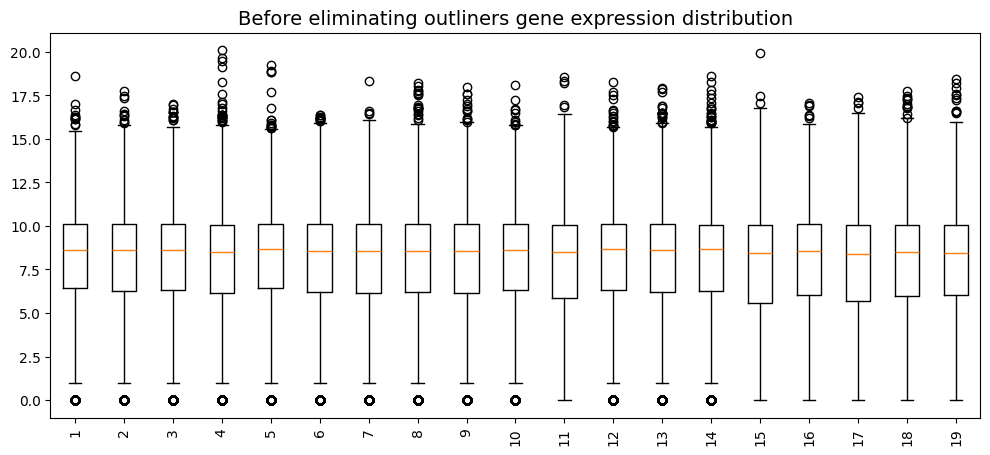

In [6]:
plt.figure(figsize=(12,5))
plt.boxplot(np.log2(df_counts[1:20].T + 1))  # transpose
plt.title("Before eliminating outliners gene expression distribution", fontsize=14)
plt.xticks(rotation=90)
plt.show()

Before eliminating the outliers (Histograms) for the mRNA-Seq

0.0
20.97843675539694
7.918521448483076


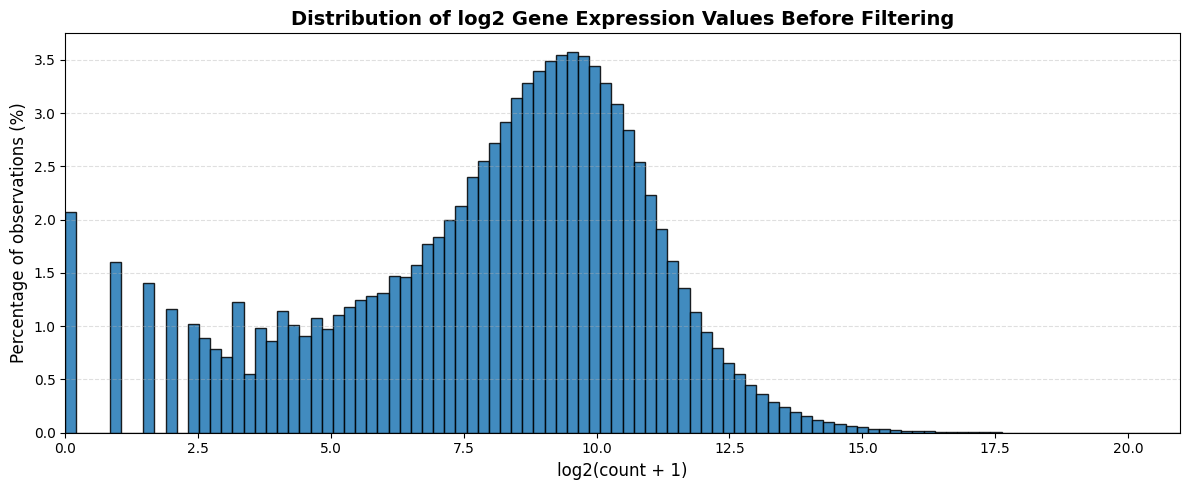

In [7]:
print(np.min(np.log2(df_counts.values + 1)))
print(np.max(np.log2(df_counts.values + 1)))
print(np.mean(np.log2(df_counts.values + 1)))

x = np.log2(df_counts.iloc[1:2000].T.values.flatten() + 1)
counts, bins = np.histogram(x, bins=100)
counts_percentage = (counts / counts.sum()) * 100
bin_width = bins[1] - bins[0]

plt.figure(figsize=(12,5))

plt.bar(
    bins[:-1],
    counts_percentage,
    width=bin_width,
    edgecolor="black",
    alpha=0.85,
    align="edge"
)
plt.title(
    "Distribution of log2 Gene Expression Values Before Filtering",
    fontsize=14,
    fontweight="bold"
)

plt.xlabel("log2(count + 1)", fontsize=12)
plt.ylabel("Percentage of observations (%)", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.xlim(0, np.max(bins))
plt.tight_layout()

plt.show()

In [8]:
#Created two groups for DeseqDataSet 
n_len = len(df_counts)
conditions = ["control"]*(n_len // 2) + ["treatment"]*(n_len - n_len//2)


In [9]:
inference = DefaultInference(n_cpus=2) #N of Cpu

metadata = pd.DataFrame({"condition":conditions}, index=df_counts.index)

print(metadata)
print(metadata.head())
print(metadata.columns)
print(metadata["condition"].values)


                 condition
TCGA-A1-A0SB-01    control
TCGA-A1-A0SD-01    control
TCGA-A1-A0SE-01    control
TCGA-A1-A0SF-01    control
TCGA-A1-A0SH-01    control
...                    ...
TCGA-MS-A51U-01  treatment
TCGA-OL-A66H-01  treatment
TCGA-OL-A66I-01  treatment
TCGA-OL-A66J-01  treatment
TCGA-OL-A66K-01  treatment

[817 rows x 1 columns]
                condition
TCGA-A1-A0SB-01   control
TCGA-A1-A0SD-01   control
TCGA-A1-A0SE-01   control
TCGA-A1-A0SF-01   control
TCGA-A1-A0SH-01   control
Index(['condition'], dtype='object')
['control' 'control' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'control' 'control' 'control' 'control'
 'control' 'control' 'control' 'c

In [10]:
deseqDataset = DeseqDataSet(
    counts=df_counts,
    metadata=metadata,
    design="~condition",
    inference=inference
)

deseqDataset.deseq2()

c:\Users\alexf\AppData\Local\Programs\Python\Python312\Lib\functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 1.09 seconds.

Fitting dispersions...
... done in 34.83 seconds.

Fitting dispersion trend curve...
... done in 0.67 seconds.

Fitting MAP dispersions...
... done in 37.96 seconds.

Fitting LFCs...
... done in 16.26 seconds.

Calculating cook's distance...
... done in 1.86 seconds.

Replacing 1489 outlier genes.

Fitting dispersions...
... done in 3.53 seconds.

Fitting MAP dispersions...
... done in 3.40 seconds.

Fitting LFCs...
... done in 2.30 seconds.



DeseqtaSet Layers

In [13]:
print(deseqDataset.layers)

Layers with keys: normed_counts, _mu_hat, cooks, replace_cooks


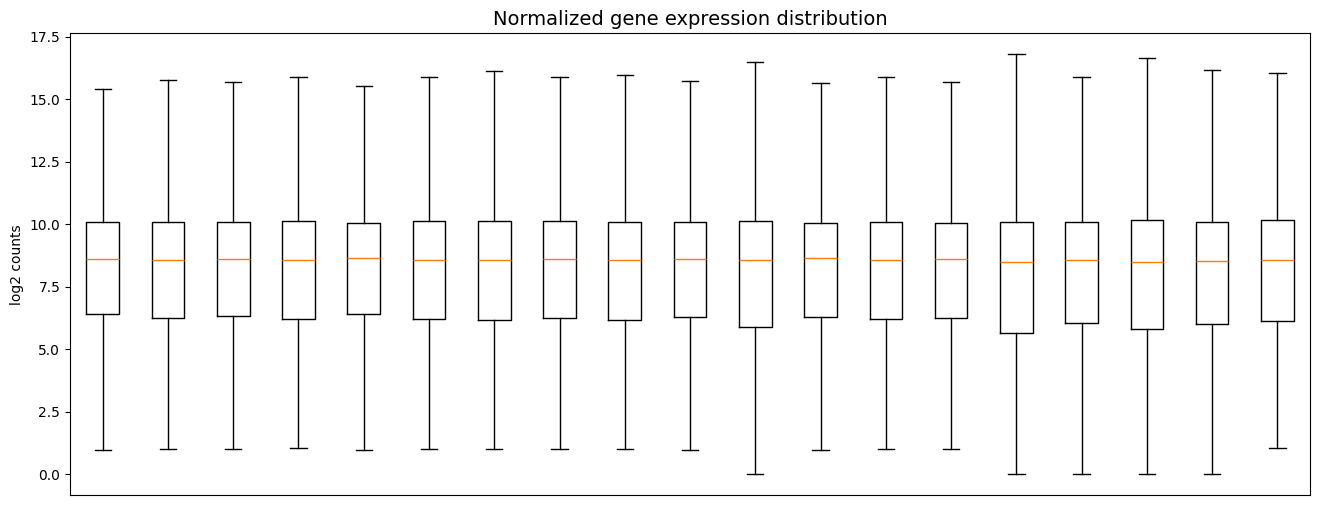

In [14]:
norm_counts = deseqDataset.layers["normed_counts"]

plt.figure(figsize=(16,6))
plt.boxplot(np.log2(norm_counts[1:20].T + 1), showfliers=False)
plt.xticks([])
plt.title("Normalized gene expression distribution", fontsize=14)
plt.ylabel("log2 counts")
plt.show()

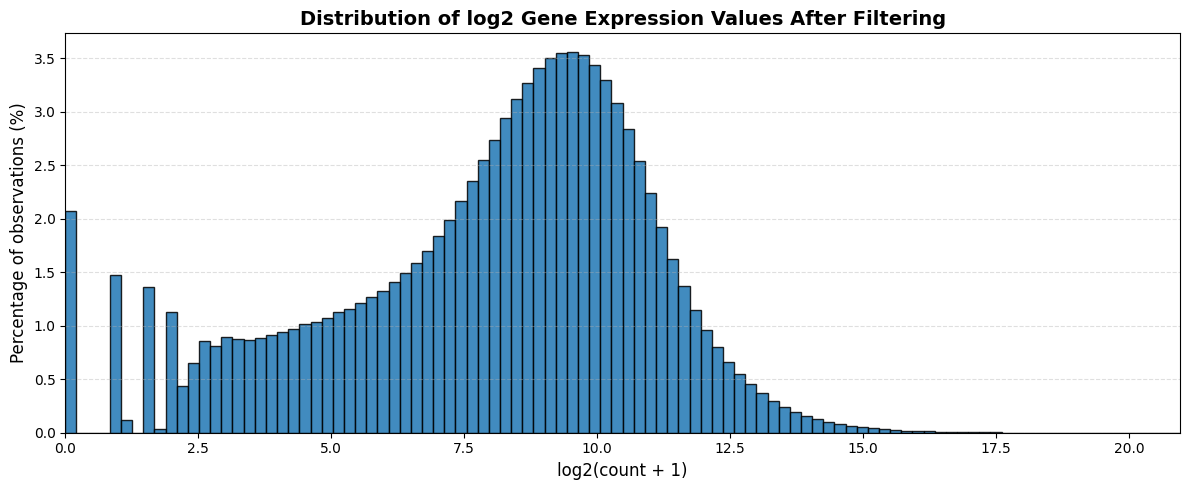

In [16]:
x = np.log2(norm_counts.flatten() + 1)
counts, bins = np.histogram(x, bins=100)
counts_percentage = (counts / counts.sum()) * 100
bin_width = bins[1] - bins[0]

plt.figure(figsize=(12,5))

plt.bar(
    bins[:-1],
    counts_percentage,
    width=bin_width,
    edgecolor="black",
    alpha=0.85,
    align="edge"
)
plt.title(
    "Distribution of log2 Gene Expression Values After Filtering",
    fontsize=14,
    fontweight="bold"
)

plt.xlabel("log2(count + 1)", fontsize=12)
plt.ylabel("Percentage of observations (%)", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.xlim(0, np.max(bins))
plt.tight_layout()

plt.show()

In [17]:
ds = DeseqStats(deseqDataset, contrast=["condition", "control", "treatment"], inference=inference)

Running Wald tests...
... done in 6.90 seconds.



Log2 fold change & Wald test p-value: condition control vs treatment
          baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
0         6.729514        0.086278  0.074973  0.000000  1.000000   1.0
1       116.404282        0.124258  0.043207  0.561443  0.574495   1.0
2       204.349404       -0.058339  0.065399  0.000000  1.000000   1.0
7         5.776558       -0.156497  0.060151 -0.939253  0.347601   1.0
14      408.272988       -0.156729  0.085453 -0.663864  0.506777   1.0
...            ...             ...       ...       ...       ...   ...
20434   935.318613       -0.021862  0.032475  0.000000  1.000000   1.0
20435  3759.215580        0.101853  0.047045  0.039382  0.968586   1.0
20436  1254.293294        0.079082  0.038951  0.000000  1.000000   1.0
20437  1006.498946       -0.079836  0.041028  0.000000  1.000000   1.0
20438   190.480034        0.089115  0.129054  0.000000  1.000000   1.0

[16309 rows x 6 columns]


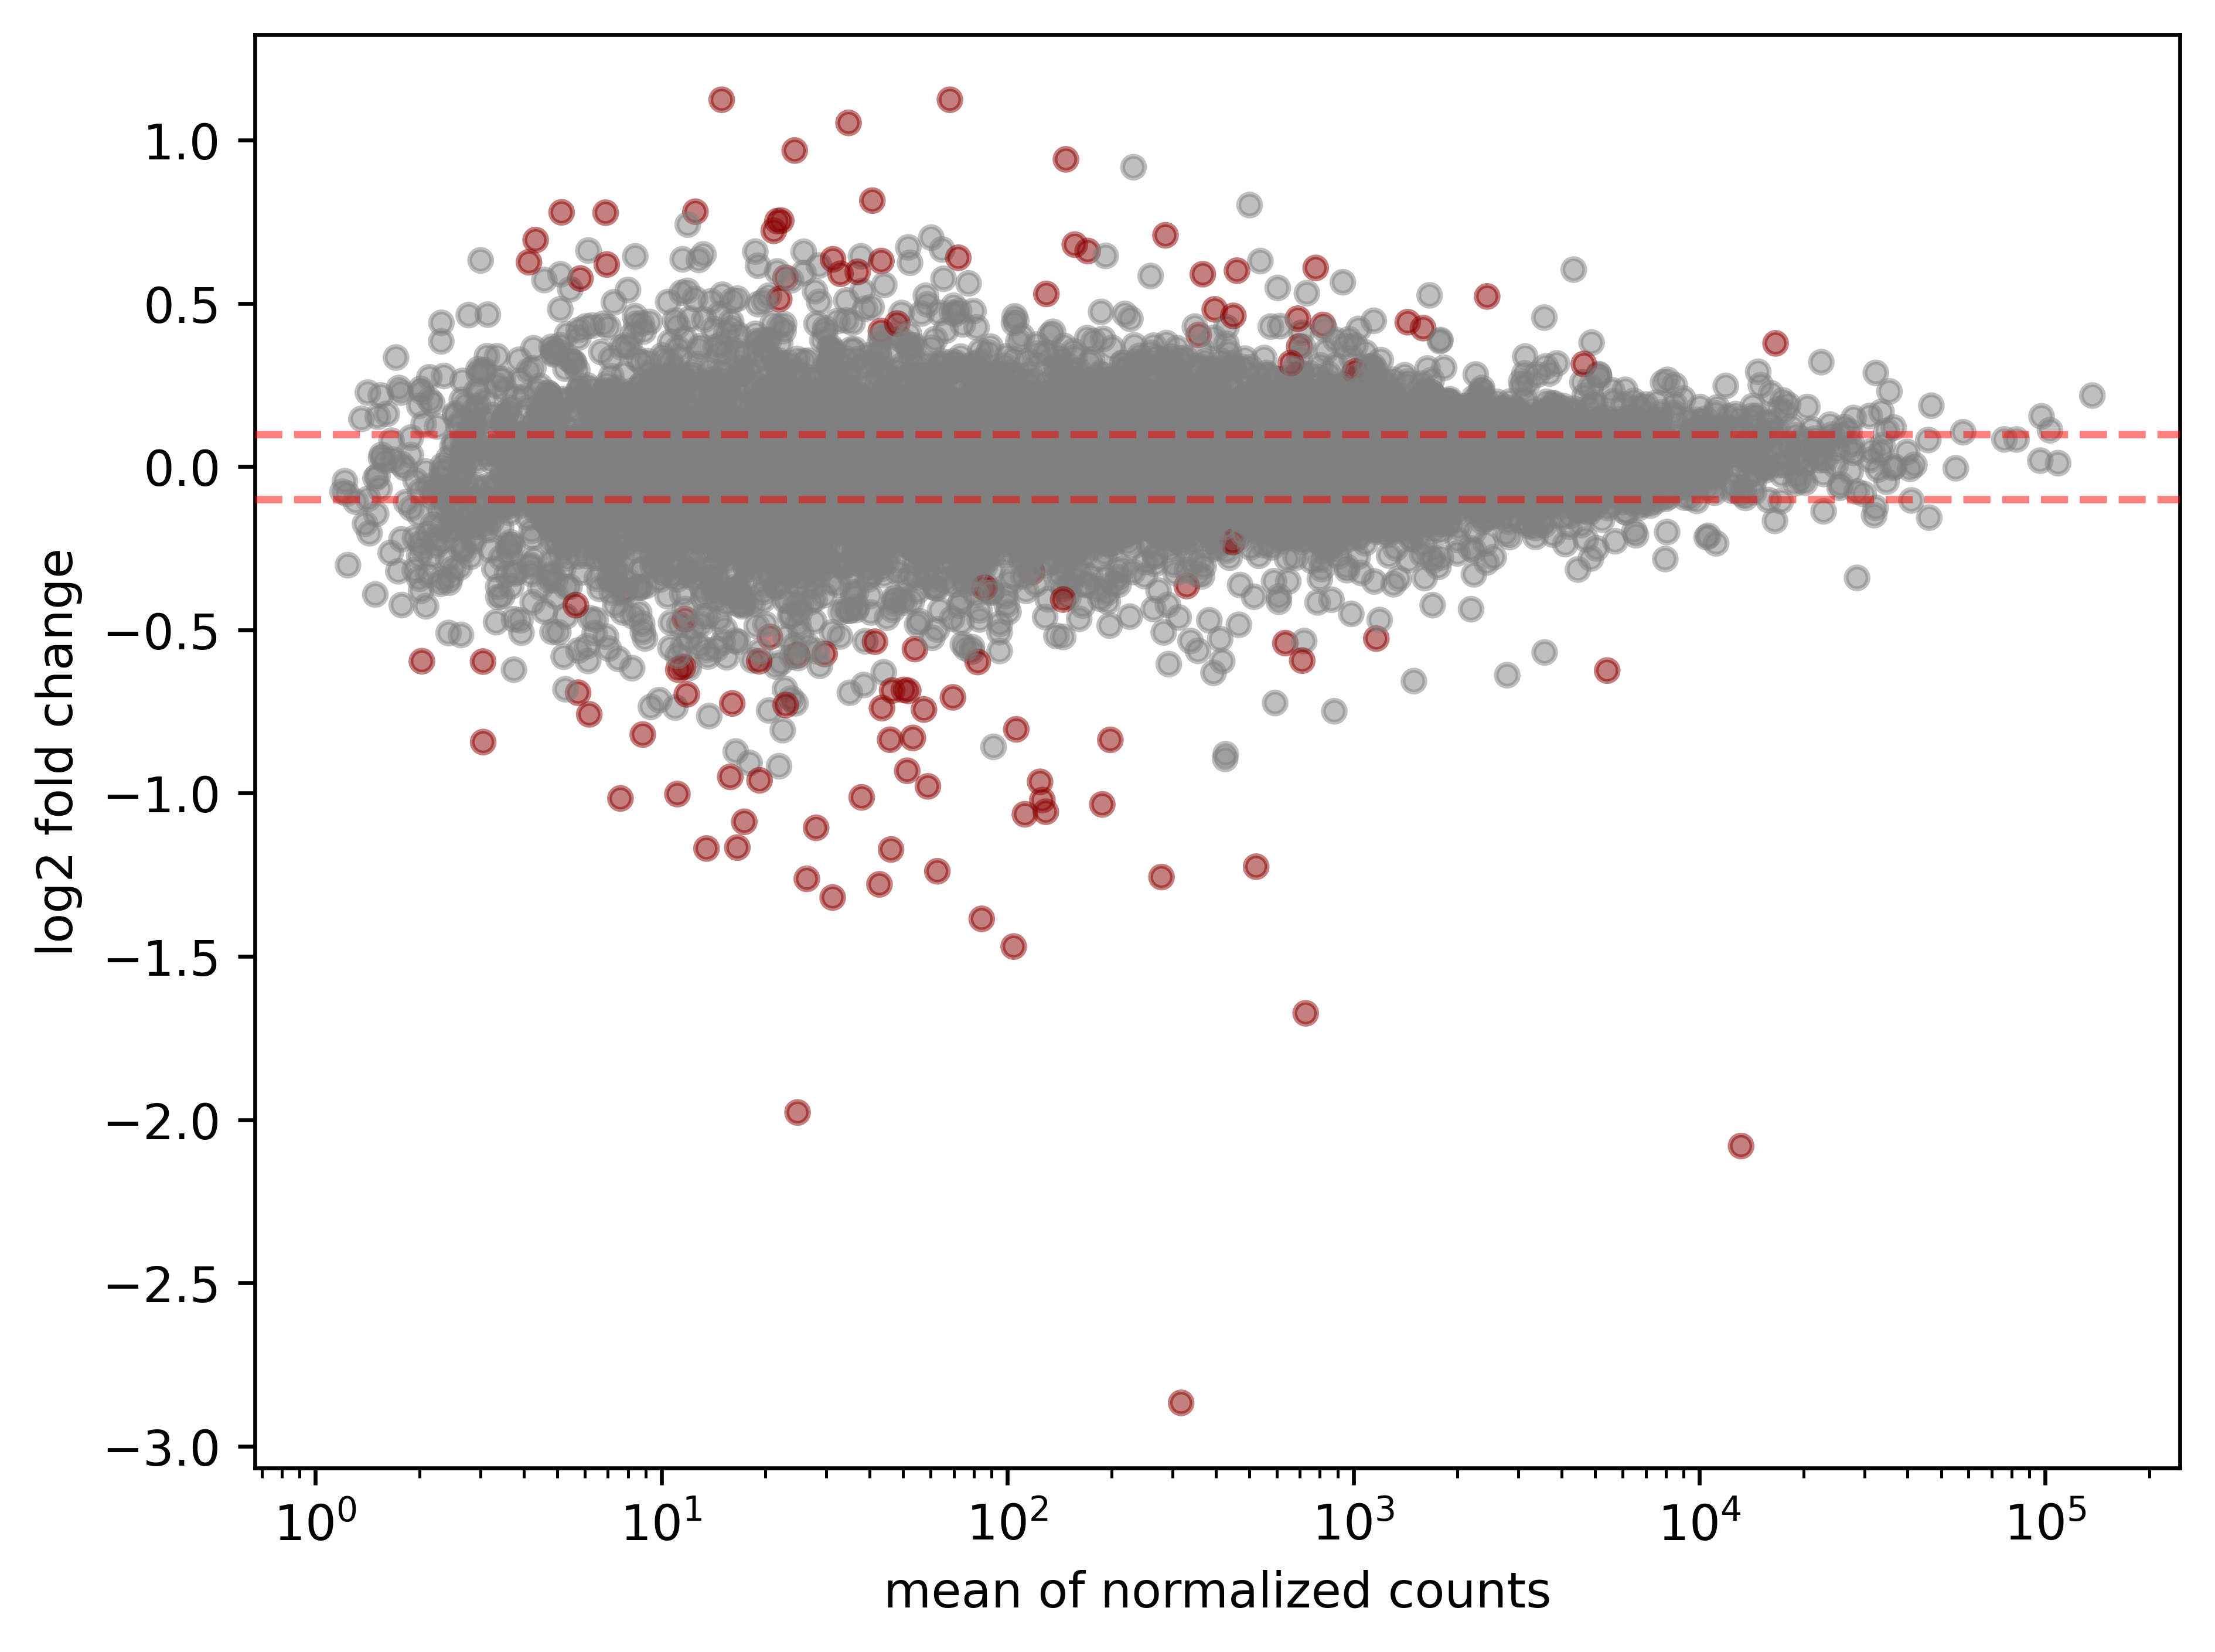

In [18]:
ds.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
ds.plot_MA(s=20)


In [19]:
norm_counts_df = pd.DataFrame(norm_counts)
print(type(norm_counts_df))
z_counts = norm_counts_df.apply(zscore, axis=1)
print(z_counts)


<class 'pandas.core.frame.DataFrame'>
        0         1         2         3         4         5         6      \
0   -0.261335 -0.239007 -0.203326 -0.264181 -0.254987 -0.178590 -0.263525   
1   -0.251916 -0.240947 -0.235798 -0.253483 -0.203786 -0.193713 -0.250797   
2   -0.287564 -0.250318 -0.270066 -0.287314 -0.213822 -0.169577 -0.263566   
3   -0.314041 -0.278151 -0.230755 -0.314315 -0.241166 -0.113223 -0.263357   
4   -0.101642 -0.096226 -0.095085 -0.101642 -0.092876 -0.076698 -0.100716   
..        ...       ...       ...       ...       ...       ...       ...   
812 -0.253626 -0.221983 -0.135682 -0.253848 -0.207157 -0.117537 -0.241234   
813 -0.155470 -0.139955 -0.109337 -0.155195 -0.100550 -0.026271 -0.153273   
814 -0.289918 -0.251083 -0.238221 -0.289671 -0.229810 -0.166240 -0.288929   
815 -0.332307 -0.296752 -0.237294 -0.332307  0.006514 -0.171562 -0.327228   
816 -0.283498 -0.256598 -0.138448 -0.284025 -0.001047 -0.052474 -0.240511   

        7         8         9      ..

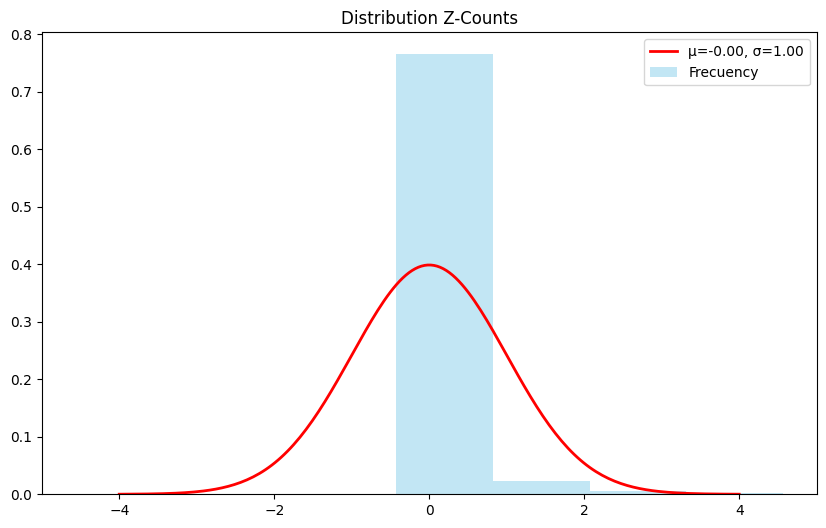

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

data = z_counts.values.ravel()


mu = np.nanmean(data) 
std = np.nanstd(data)

counts, bins = np.histogram(data, bins=100, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, counts, width=(bins[1]-bins[0]), color='skyblue', alpha=0.5, label='Frecuency')

x = np.linspace(mu - 4*std, mu + 4*std, 200)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', lw=2, label=f'μ={mu:.2f}, σ={std:.2f}')

plt.title("Distribution Z-Counts")
plt.xlim(-5, 5)
plt.legend()
plt.show()

In [25]:
upper_outliers = np.sum(data > 3)
down_outliers = np.sum(data < -3)
total = len(data)
print(f"total of data: {total}")
print(f"Outliers Upper (>3): {upper_outliers} ({100*upper_outliers/total:.4f}%)")
print(f"Outliers Down (<-3): {down_outliers} ({100*down_outliers/total:.4f}%)")

total of data: 13324453
Outliers Upper (>3): 116417 (0.8737%)
Outliers Down (<-3): 0 (0.0000%)
